TODO: 
* modify pipeline, more options
* test data as whole, not couple of chunks
* visualisation for

In [1]:
from IPython.core.debugger import set_trace

In [2]:
import numpy as np
from numpy.random import seed
seed(1)
#display all values from array
np.set_printoptions(threshold=np.nan)
#display not in scientific format
np.set_printoptions(suppress=True)

from tensorflow import set_random_seed
set_random_seed(2)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pickle
INPUT_DATA_FILE_PATH='tmp/input.pckl'

In [3]:
DATA_FREQUENCY = 500
SAMPLING_RATE = 5
FREQUENCY_TO_SAMPLING_RATIO = DATA_FREQUENCY // SAMPLING_RATE
CHUNK_SIZE_IN_SECONDS = 4

In [4]:
from data_reader import read_data

(input_data, target, headers) = read_data(data_path='data', 
                                          sampling_rate=SAMPLING_RATE, 
                                          data_frequency=DATA_FREQUENCY)

Loaded input file: 1
Loaded input file: 2
Loaded input file: 3
Loaded input file: 4
Loaded input file: 5
Loaded input file: 6
Loaded input file: 7
Loaded input file: 8
Loaded input file: 9
Loaded input file: 10
Loaded input file: 11
Loaded input file: 12
Loaded input file: 13
Loaded input file: 14
Loaded input file: 15
Loaded input file: 16
Loaded input file: 17
Loaded input file: 18
Loaded input file: 19
Loaded input file: 20
Loaded input file: 21
Loaded input file: 22
Loaded input file: 23
Loaded input file: 24
Loaded input file: 25
Loaded input file: 26
Loaded input file: 27
Loaded input file: 28
Loaded input file: 29
Loaded input file: 30
Loaded input file: 31
Loaded input file: 32
Loaded input file: 33
Loaded input file: 34
Loaded input file: 35
Loaded input file: 36
Loaded input file: 37
Loaded input file: 38
Loaded input file: 39
Loaded input file: 40
Loaded input file: 41
Loaded input file: 42
Loaded input file: 43
Loaded input file: 44
Loaded input file: 45
Loaded input file: 

In [5]:
with open(INPUT_DATA_FILE_PATH, 'wb') as input_variable_file:
    pickle.dump([input_data, target, headers], input_variable_file)

del input_data, target, headers

In [25]:
def plot_results(history):
    import matplotlib.pyplot as plt

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [26]:
from time import time
import datetime

def create_current_time():
    timestamp = time()
    return datetime.datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')

In [77]:
from chunks_creator import prepare_chunks
from chunks_creator import flatten_chunks

def normalize(x, y):
    scalers = {}
    for channel_number in range(x.shape[1]):
        scalers[channel_number] = StandardScaler()
        x[:, channel_number, :] = scalers[channel_number].fit_transform(x[:, channel_number, :]) 
    return x, y.astype(int)


def load_input_data():
    with open(INPUT_DATA_FILE_PATH, 'rb') as input_data_file:
        input_data, target, headers = pickle.load(input_data_file)
    
    return input_data, target, headers


def prepare_data():
    input_data, target, headers = load_input_data()
    
    chunks_input, chunks_target = prepare_chunks(input_data, 
                                                target, 
                                                chunk_size_in_seconds=CHUNK_SIZE_IN_SECONDS, 
                                                ratio=FREQUENCY_TO_SAMPLING_RATIO)
    x, y = flatten_chunks(chunks_input, chunks_target)
    x, y = normalize(x, y)

    x_train, x_test, y_train, y_test = train_test_split(x, 
                                                        y, 
                                                        test_size=0.05, 
                                                        # later delete this seed
                                                        random_state=42)
    return x_train, x_test, y_train, y_test

In [93]:
from keras.models import Sequential
from keras.models import Sequential

from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, LSTM

from keras.optimizers import RMSprop

from keras import callbacks

In [28]:
def callbacks_list(description): 
    return [
#     callbacks.EarlyStopping(
#         monitor='val_acc', 
#         patience=5
#     ),
    callbacks.ModelCheckpoint(
        filepath='tmp/best_model.h5', 
        monitor='val_loss', 
        save_best_only=True
    ),
    callbacks.TensorBoard(
        log_dir='tmp/logs/{}:{}'.format(description, create_current_time()),
        histogram_freq=0, #it has to be 0, otherwise throws error during training
        write_graph=True,
        write_images=True
    )
]

In [29]:
def create_fully_connected_model(input_shape):
    model = Sequential()
    model.add(layers.Flatten(input_shape=input_shape))
    model.add(layers.Dense(1000, activation='relu'))
    model.add(layers.Dense(30, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

In [30]:
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=False, input_shape=input_shape))
    # model.add(Dropout(0.5))
    #model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [31]:
from keras.layers import Dense, Embedding, SimpleRNN

def create_simple_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(32, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [83]:
# ~70-80% test, overfitting
def create_conv_1D_model(input_shape):
    description = "conv1D-2lay:64,32"
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model, description

#less overfitting
def create_conv_1D_model_smaller(input_shape):
    description = "conv1D-2lay:smaller"
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=6, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=16, kernel_size=6, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model, description

In [117]:
def run_pipeline(iterations):
    score = []
    best_model_score = []
    
    x_train, x_test, y_train, y_test = prepare_data()
    
    for iteration in range(0, iterations):
        input_shape = x_train.shape[1:]

        model, model_description = create_conv_1D_model(input_shape)
        model, model_description = create_conv_1D_model_smaller(input_shape)

        learning_rate = 0.0001
        description = "lr = {}".format(learning_rate)

        model.compile(optimizer=RMSprop(lr=learning_rate),
                      loss='binary_crossentropy',
                      metrics=['acc'])

        history = model.fit(x_train,
                            y_train,
                            epochs=100,
                            batch_size=16,
                            callbacks=callbacks_list("{}. {}-{}".format(model_description, description, iteration)),
                            validation_split=0.1)

        score.append(model.evaluate(x_test, y_test, batch_size=16))
        
        model.load_weights("tmp/best_model.h5")
        best_model_score.append(model.evaluate(x_test, y_test, batch_size=16))
        
        
    return score, best_model_score

In [118]:
iterations = 3
score, best_model_score = run_pipeline(iterations)

Train on 1005 samples, validate on 112 samples
Epoch 1/100
1005/1005 [==============================] - 1s 630us/step - loss: 0.7835 - acc: 0.5672 - val_loss: 0.6585 - val_acc: 0.6250
Epoch 2/100
1005/1005 [==============================] - 0s 321us/step - loss: 0.6876 - acc: 0.6179 - val_loss: 0.6487 - val_acc: 0.6429
Epoch 3/100
1005/1005 [==============================] - 0s 312us/step - loss: 0.6659 - acc: 0.6607 - val_loss: 0.6477 - val_acc: 0.6607
Epoch 4/100
1005/1005 [==============================] - 0s 316us/step - loss: 0.6338 - acc: 0.6856 - val_loss: 0.6331 - val_acc: 0.6696
Epoch 5/100
1005/1005 [==============================] - 0s 325us/step - loss: 0.6475 - acc: 0.6985 - val_loss: 0.6589 - val_acc: 0.6429
Epoch 6/100
1005/1005 [==============================] - 0s 327us/step - loss: 0.6198 - acc: 0.7065 - val_loss: 0.6354 - val_acc: 0.6518
Epoch 7/100
1005/1005 [==============================] - 0s 311us/step - loss: 0.5988 - acc: 0.7234 - val_loss: 0.6232 - val_acc: 0

1005/1005 [==============================] - 0s 313us/step - loss: 0.3106 - acc: 0.8866 - val_loss: 0.6612 - val_acc: 0.6964
Epoch 61/100
1005/1005 [==============================] - 0s 311us/step - loss: 0.3250 - acc: 0.8736 - val_loss: 0.6646 - val_acc: 0.6964
Epoch 62/100
1005/1005 [==============================] - 0s 301us/step - loss: 0.3179 - acc: 0.8706 - val_loss: 0.6566 - val_acc: 0.6964
Epoch 63/100
1005/1005 [==============================] - 0s 307us/step - loss: 0.3164 - acc: 0.8677 - val_loss: 0.6669 - val_acc: 0.6696
Epoch 64/100
1005/1005 [==============================] - 0s 316us/step - loss: 0.3125 - acc: 0.8736 - val_loss: 0.6631 - val_acc: 0.6786
Epoch 65/100
1005/1005 [==============================] - 0s 299us/step - loss: 0.3160 - acc: 0.8677 - val_loss: 0.6659 - val_acc: 0.6964
Epoch 66/100
1005/1005 [==============================] - 0s 299us/step - loss: 0.3087 - acc: 0.8826 - val_loss: 0.6739 - val_acc: 0.7054
Epoch 67/100
1005/1005 [=======================

1005/1005 [==============================] - 0s 319us/step - loss: 0.5114 - acc: 0.7811 - val_loss: 0.5801 - val_acc: 0.6964
Epoch 19/100
1005/1005 [==============================] - 0s 308us/step - loss: 0.4902 - acc: 0.7910 - val_loss: 0.5823 - val_acc: 0.7054
Epoch 20/100
1005/1005 [==============================] - 0s 301us/step - loss: 0.4770 - acc: 0.7881 - val_loss: 0.5911 - val_acc: 0.6964
Epoch 21/100
1005/1005 [==============================] - 0s 305us/step - loss: 0.4813 - acc: 0.7980 - val_loss: 0.6009 - val_acc: 0.6875
Epoch 22/100
1005/1005 [==============================] - 0s 303us/step - loss: 0.4456 - acc: 0.8129 - val_loss: 0.5716 - val_acc: 0.7143
Epoch 23/100
1005/1005 [==============================] - 0s 301us/step - loss: 0.4750 - acc: 0.8000 - val_loss: 0.6098 - val_acc: 0.6964
Epoch 24/100
1005/1005 [==============================] - 0s 306us/step - loss: 0.4568 - acc: 0.8080 - val_loss: 0.6298 - val_acc: 0.6607
Epoch 25/100
1005/1005 [=======================

1005/1005 [==============================] - 0s 305us/step - loss: 0.2684 - acc: 0.8975 - val_loss: 0.6742 - val_acc: 0.6786
Epoch 78/100
1005/1005 [==============================] - 0s 303us/step - loss: 0.3111 - acc: 0.8876 - val_loss: 0.6380 - val_acc: 0.6875
Epoch 79/100
1005/1005 [==============================] - 0s 309us/step - loss: 0.2703 - acc: 0.8955 - val_loss: 0.6884 - val_acc: 0.6696
Epoch 80/100
1005/1005 [==============================] - 0s 306us/step - loss: 0.2758 - acc: 0.8985 - val_loss: 0.6723 - val_acc: 0.6875
Epoch 81/100
1005/1005 [==============================] - 0s 314us/step - loss: 0.2573 - acc: 0.9085 - val_loss: 0.6861 - val_acc: 0.6786
Epoch 82/100
1005/1005 [==============================] - 0s 310us/step - loss: 0.2651 - acc: 0.9015 - val_loss: 0.7008 - val_acc: 0.6607
Epoch 83/100
1005/1005 [==============================] - 0s 305us/step - loss: 0.2699 - acc: 0.9045 - val_loss: 0.6937 - val_acc: 0.6518
Epoch 84/100
1005/1005 [=======================

1005/1005 [==============================] - 0s 322us/step - loss: 0.3909 - acc: 0.8328 - val_loss: 0.6218 - val_acc: 0.7054
Epoch 36/100
1005/1005 [==============================] - 0s 325us/step - loss: 0.3867 - acc: 0.8239 - val_loss: 0.6126 - val_acc: 0.7232
Epoch 37/100
1005/1005 [==============================] - 0s 307us/step - loss: 0.3830 - acc: 0.8468 - val_loss: 0.6224 - val_acc: 0.6875
Epoch 38/100
1005/1005 [==============================] - 0s 312us/step - loss: 0.3678 - acc: 0.8587 - val_loss: 0.6535 - val_acc: 0.6786
Epoch 39/100
1005/1005 [==============================] - 0s 309us/step - loss: 0.3577 - acc: 0.8527 - val_loss: 0.6419 - val_acc: 0.6786
Epoch 40/100
1005/1005 [==============================] - 0s 324us/step - loss: 0.3750 - acc: 0.8418 - val_loss: 0.6966 - val_acc: 0.6339
Epoch 41/100
1005/1005 [==============================] - 0s 317us/step - loss: 0.3679 - acc: 0.8537 - val_loss: 0.6525 - val_acc: 0.6875
Epoch 42/100
1005/1005 [=======================

1005/1005 [==============================] - 0s 324us/step - loss: 0.2483 - acc: 0.9075 - val_loss: 0.7932 - val_acc: 0.6696
Epoch 95/100
1005/1005 [==============================] - 0s 312us/step - loss: 0.2439 - acc: 0.8985 - val_loss: 0.7854 - val_acc: 0.6786
Epoch 96/100
1005/1005 [==============================] - 0s 301us/step - loss: 0.2267 - acc: 0.9144 - val_loss: 0.7810 - val_acc: 0.6696
Epoch 97/100
1005/1005 [==============================] - 0s 305us/step - loss: 0.2346 - acc: 0.9154 - val_loss: 0.7611 - val_acc: 0.6964
Epoch 98/100
1005/1005 [==============================] - 0s 305us/step - loss: 0.2085 - acc: 0.9234 - val_loss: 0.7890 - val_acc: 0.6786
Epoch 99/100
1005/1005 [==============================] - 0s 302us/step - loss: 0.2117 - acc: 0.9264 - val_loss: 0.7943 - val_acc: 0.6786
Epoch 100/100
59/59 [==============================] - 0s 209us/step


In [119]:
print("Test accuracy:")
for iteration in range(0, iterations):
    print("-Iteration: {}".format(iteration))
    print("--Last epoch accuracy: %.2f%%" % (score[iteration][1]*100))
    print("--Best model accuracy: %.2f%%" % (best_model_score[iteration][1]*100))

Test accuracy:
-Iteration: 0
--Last epoch accuracy: 81.36%
--Best model accuracy: 79.66%
-Iteration: 1
--Last epoch accuracy: 76.27%
--Best model accuracy: 76.27%
-Iteration: 2
--Last epoch accuracy: 81.36%
--Best model accuracy: 77.97%


In [91]:
x_train, x_test, y_train, y_test = prepare_data()

input_shape = x_train.shape[1:]

# model = create_fully_connected_model(input_shape)
# model = create_lstm_model(input_shape)
# model = create_simple_rnn_model(input_shape)

# model, model_description = create_conv_1D_model(input_shape)
model, model_description = create_conv_1D_model_smaller(input_shape)

learning_rate = 0.0001
description = "lr = {}".format(learning_rate)

model.compile(optimizer=RMSprop(lr=learning_rate),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train,
                    y_train,
                    epochs=100,
                    batch_size=16,
                    callbacks=callbacks_list("{}. {}".format(model_description, description)),
                    validation_split=0.1)

score = model.evaluate(x_test, y_test, batch_size=16)

model.load_weights("tmp/best_model.h5")
best_model_score = model.evaluate(x_test, y_test, batch_size=16)

Train on 1005 samples, validate on 112 samples
Epoch 1/100
1005/1005 [==============================] - 1s 541us/step - loss: 0.7924 - acc: 0.5353 - val_loss: 0.7056 - val_acc: 0.4732
Epoch 2/100
1005/1005 [==============================] - 0s 303us/step - loss: 0.7668 - acc: 0.5642 - val_loss: 0.6979 - val_acc: 0.5089
Epoch 3/100
1005/1005 [==============================] - 0s 299us/step - loss: 0.6844 - acc: 0.6458 - val_loss: 0.6830 - val_acc: 0.5625
Epoch 4/100
1005/1005 [==============================] - 0s 310us/step - loss: 0.6854 - acc: 0.6607 - val_loss: 0.6755 - val_acc: 0.5446
Epoch 5/100
1005/1005 [==============================] - 0s 300us/step - loss: 0.6813 - acc: 0.6448 - val_loss: 0.6735 - val_acc: 0.5625
Epoch 6/100
1005/1005 [==============================] - 0s 309us/step - loss: 0.6539 - acc: 0.6537 - val_loss: 0.6620 - val_acc: 0.6429
Epoch 7/100
1005/1005 [==============================] - 0s 297us/step - loss: 0.6477 - acc: 0.6786 - val_loss: 0.6554 - val_acc: 0

1005/1005 [==============================] - 0s 315us/step - loss: 0.4031 - acc: 0.8328 - val_loss: 0.5685 - val_acc: 0.7321
Epoch 61/100
1005/1005 [==============================] - 0s 315us/step - loss: 0.3888 - acc: 0.8318 - val_loss: 0.5713 - val_acc: 0.7232
Epoch 62/100
1005/1005 [==============================] - 0s 293us/step - loss: 0.4003 - acc: 0.8269 - val_loss: 0.5582 - val_acc: 0.7054
Epoch 63/100
1005/1005 [==============================] - 0s 315us/step - loss: 0.4040 - acc: 0.8448 - val_loss: 0.5622 - val_acc: 0.7143
Epoch 64/100
1005/1005 [==============================] - 0s 313us/step - loss: 0.4034 - acc: 0.8348 - val_loss: 0.5745 - val_acc: 0.7411
Epoch 65/100
1005/1005 [==============================] - 0s 300us/step - loss: 0.4101 - acc: 0.8328 - val_loss: 0.5716 - val_acc: 0.7321
Epoch 66/100
1005/1005 [==============================] - 0s 296us/step - loss: 0.3847 - acc: 0.8438 - val_loss: 0.5682 - val_acc: 0.7232
Epoch 67/100
1005/1005 [=======================

Test accuracy:
Last epoch accuracy: 79.66%
Best model accuracy: 77.97%


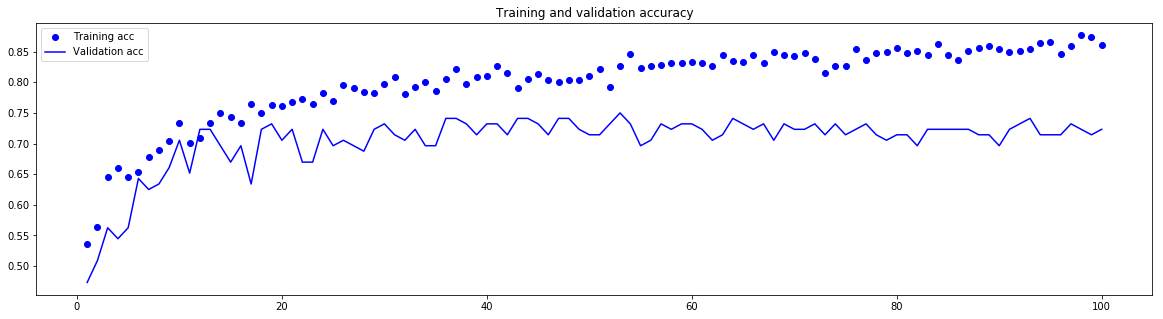

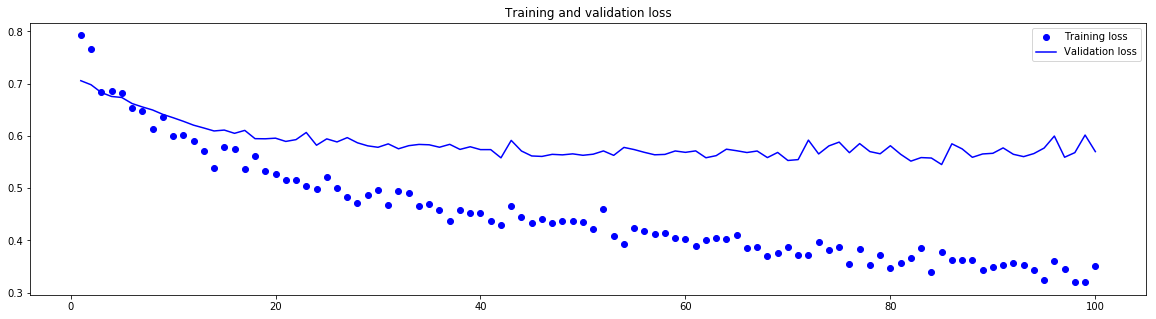

In [92]:
print("Test accuracy:")
print("Last epoch accuracy: %.2f%%" % (score[1]*100))
print("Best model accuracy: %.2f%%" % (best_model_score[1]*100))
plot_results(history)

In [36]:
from plots_printer import draw_plots, draw_plots_with_chunks

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]

In [41]:
input_data, target, headers = load_input_data()
chunks_input, chunks_target = prepare_chunks(input_data, 
                                            target, 
                                            chunk_size_in_seconds=CHUNK_SIZE_IN_SECONDS, 
                                            ratio=FREQUENCY_TO_SAMPLING_RATIO)

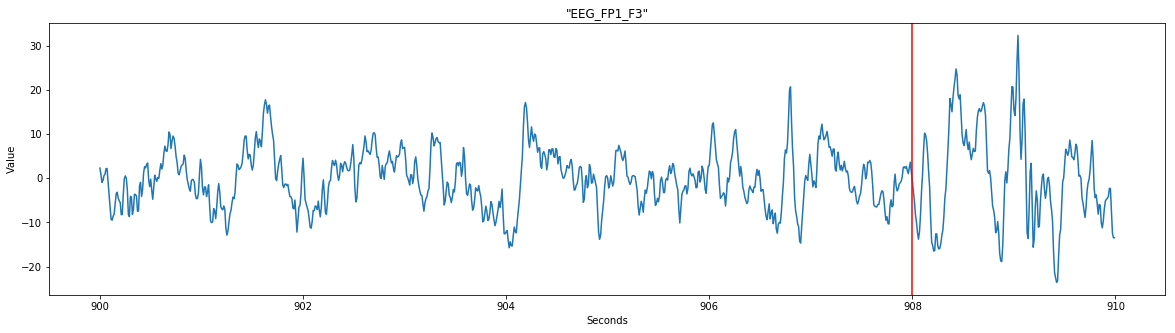

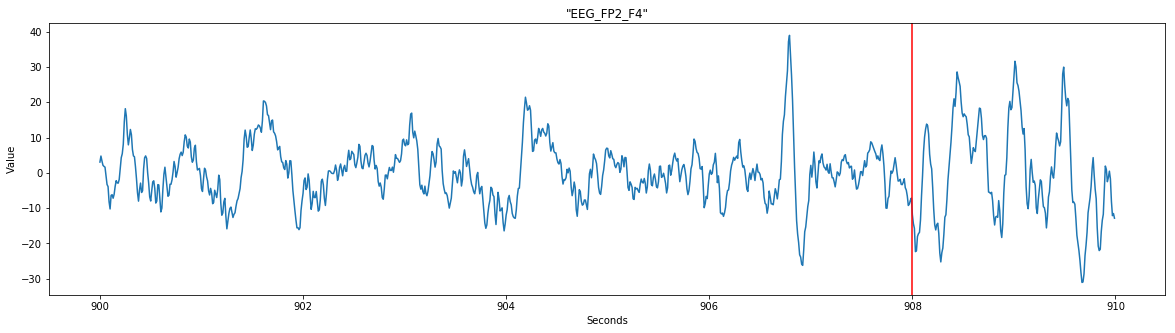

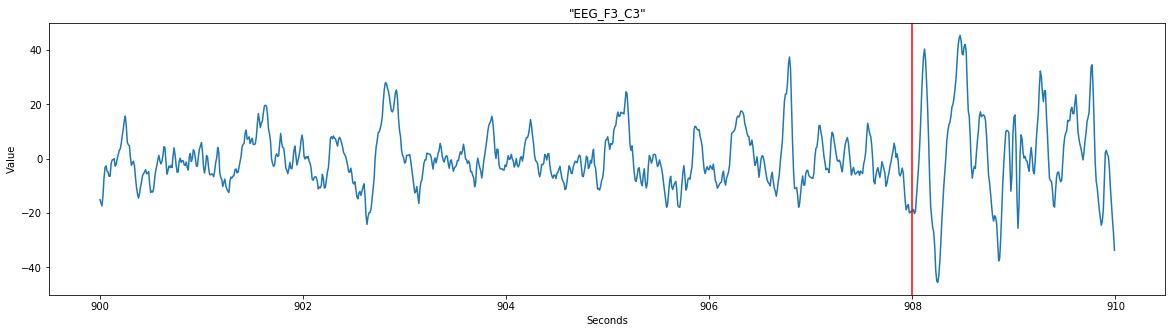

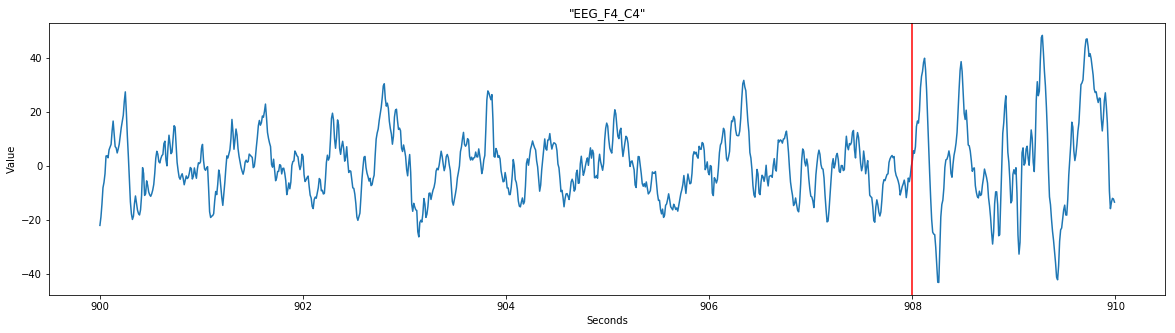

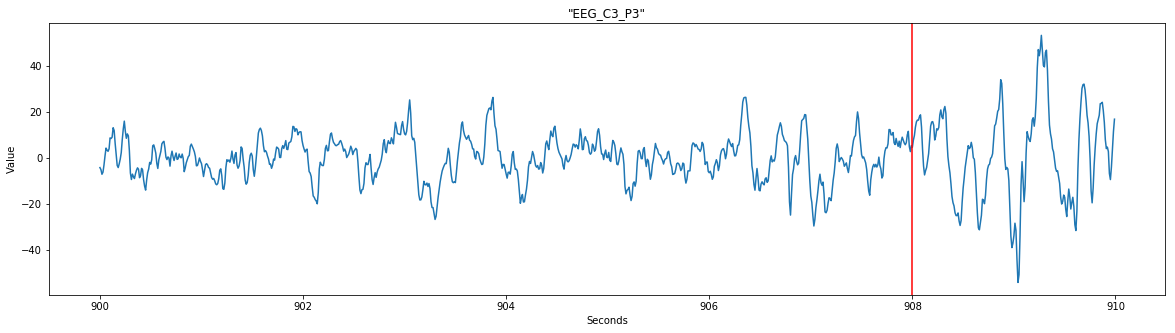

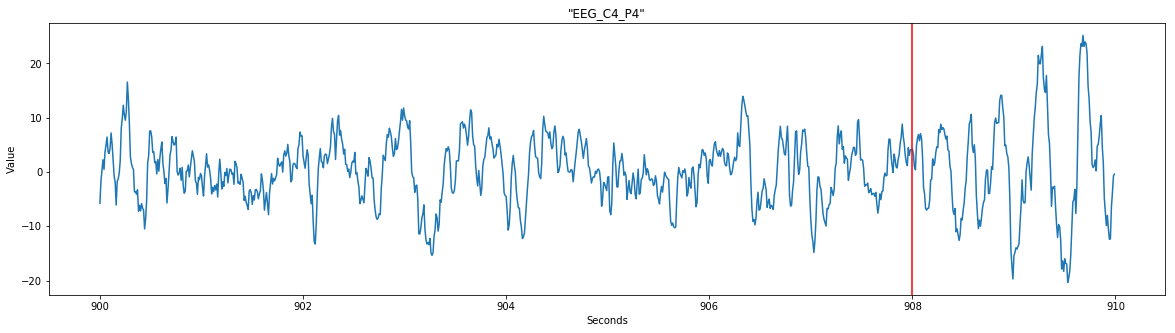

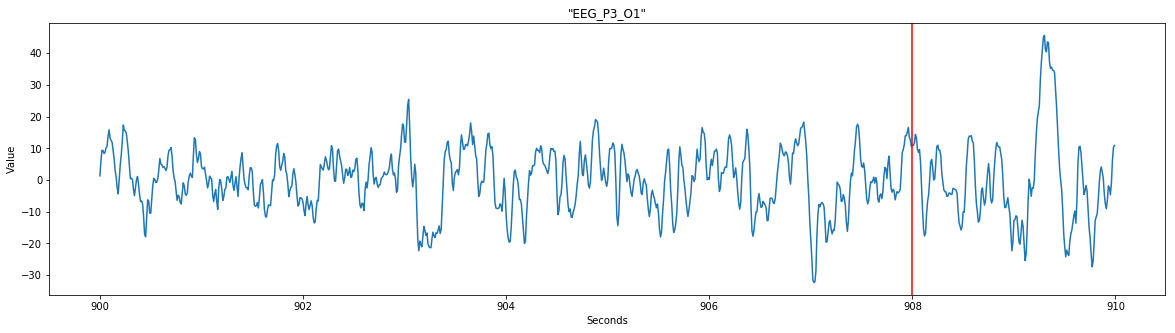

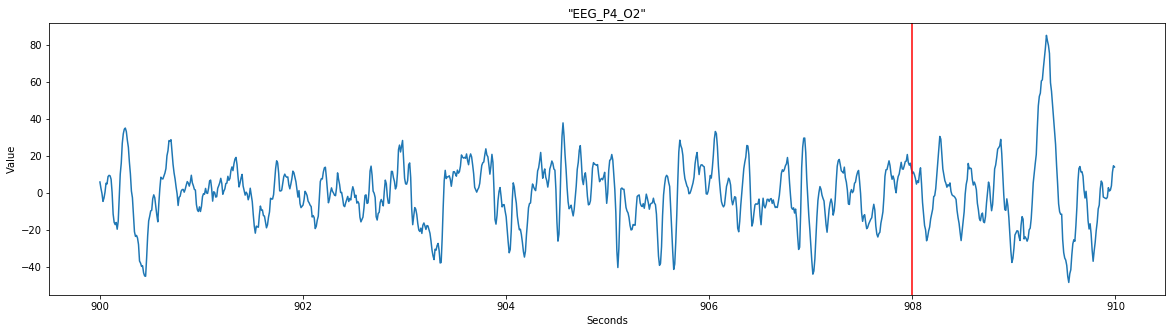

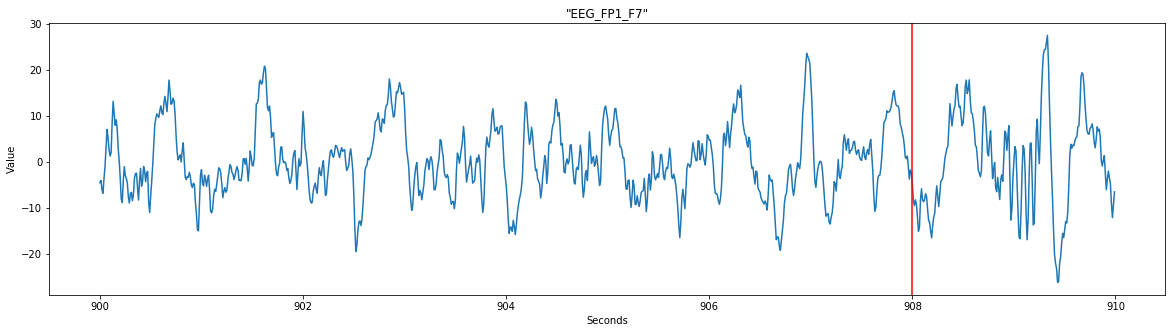

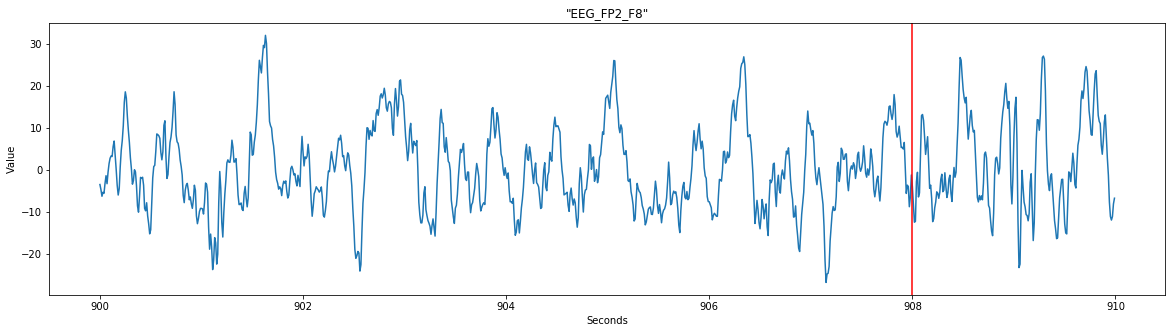

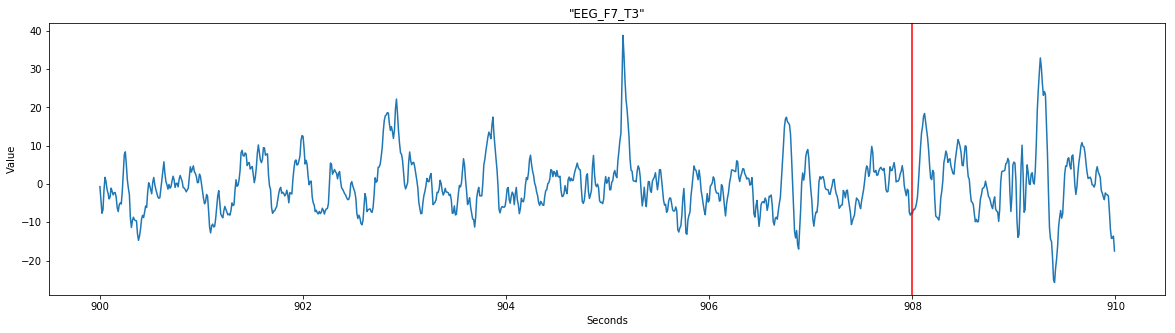

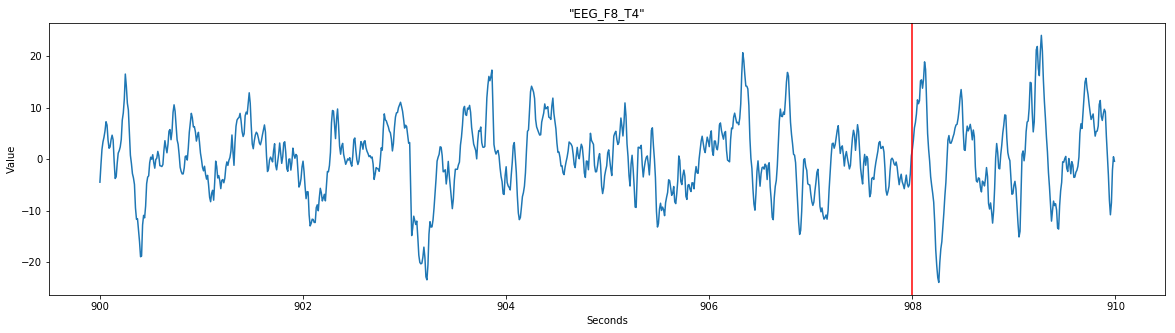

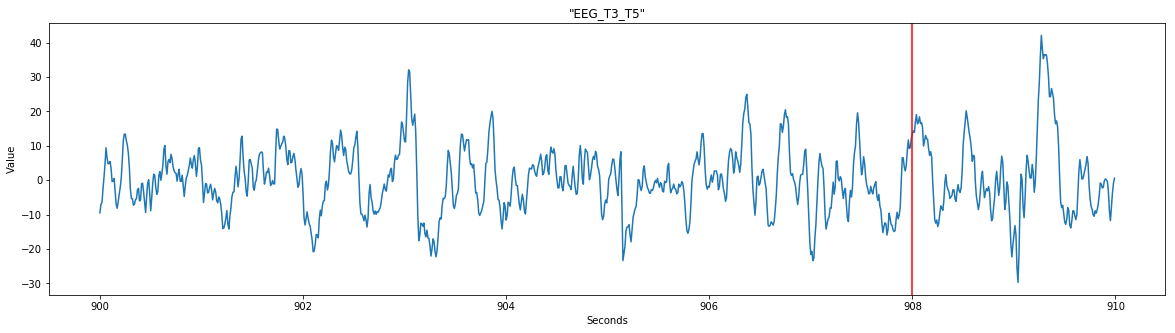

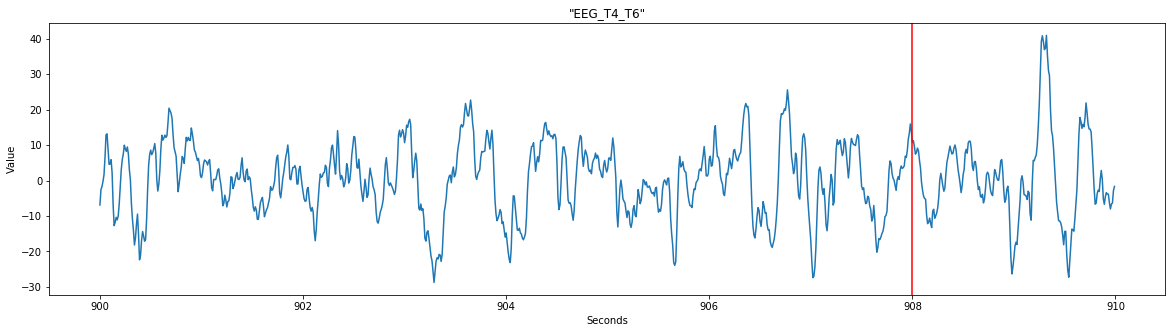

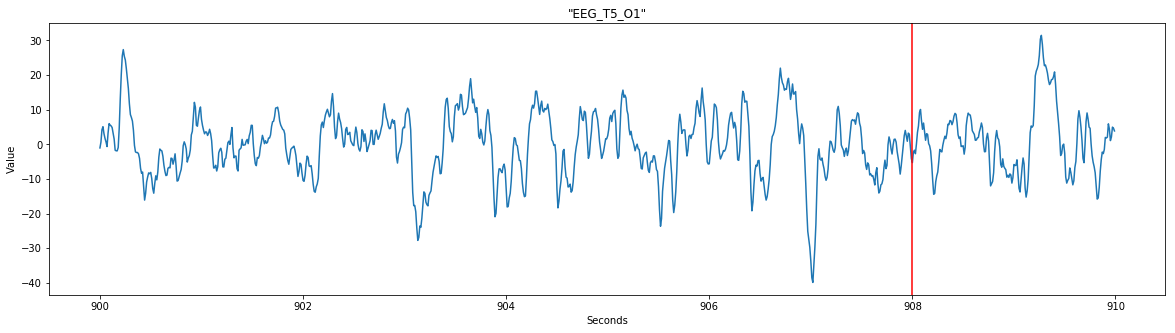

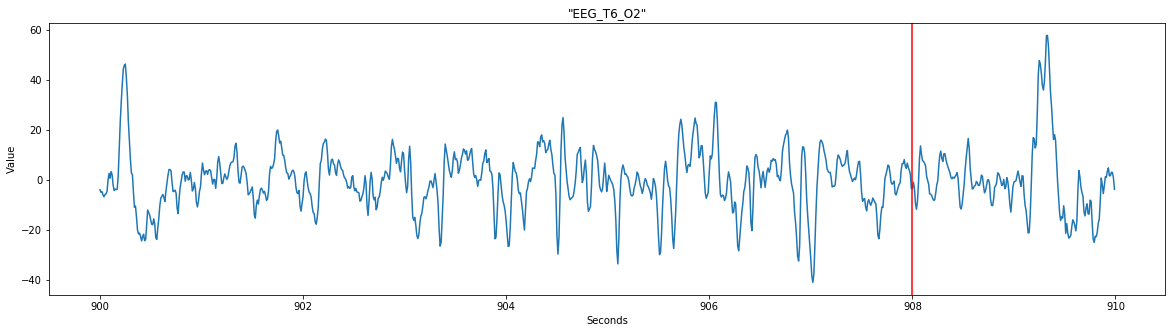

In [42]:
draw_plots(input_data, 
           target, 
           headers, 
           patient=0, 
           start_second=900, 
           end_second=910,
           ratio=FREQUENCY_TO_SAMPLING_RATIO)

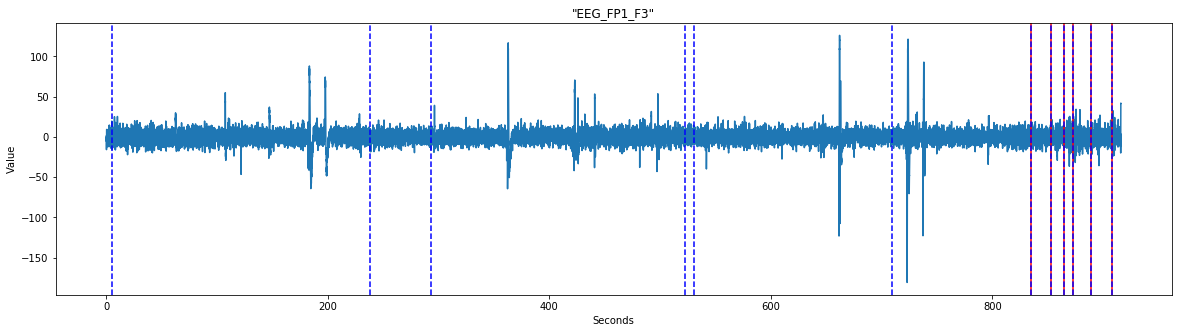

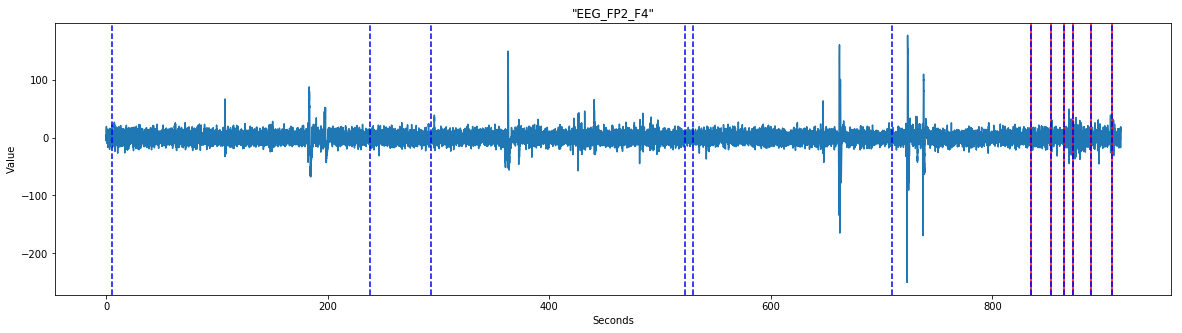

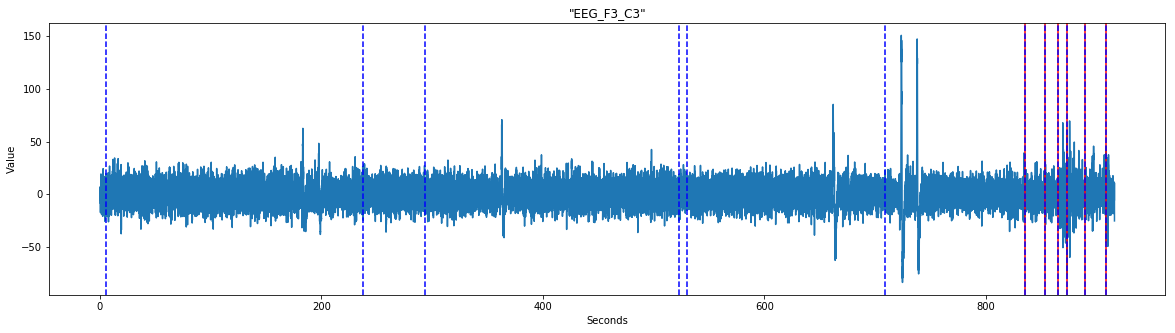

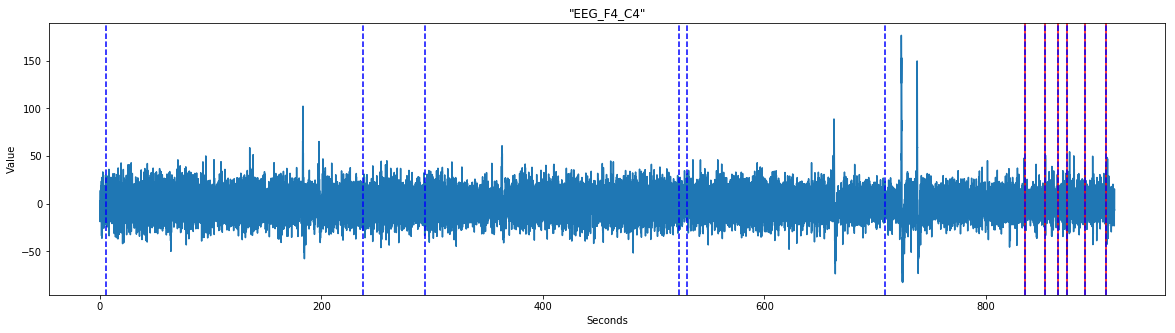

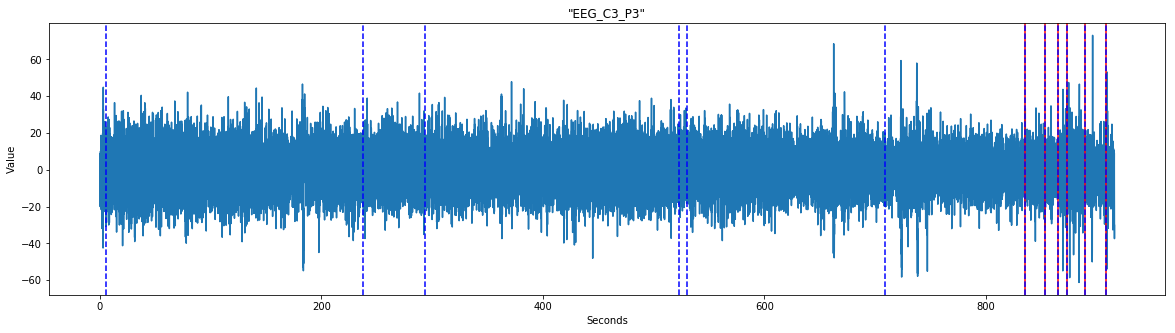

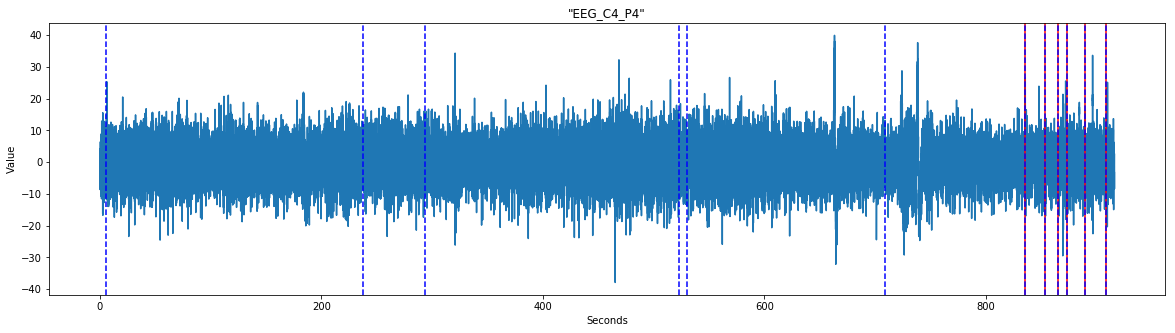

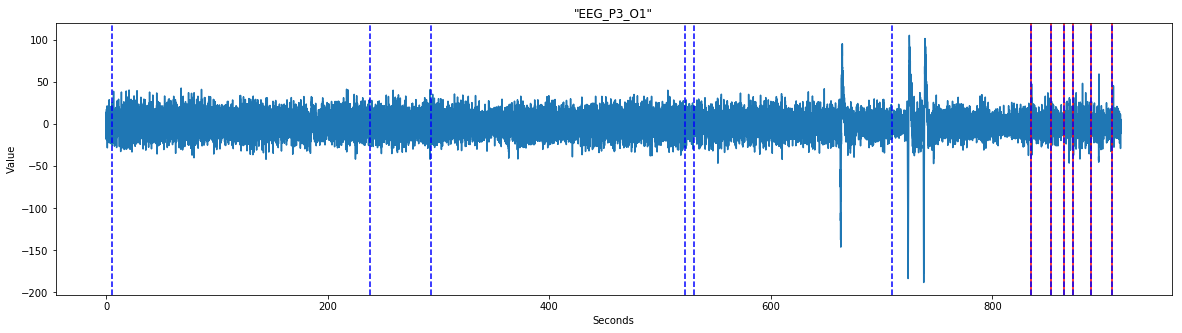

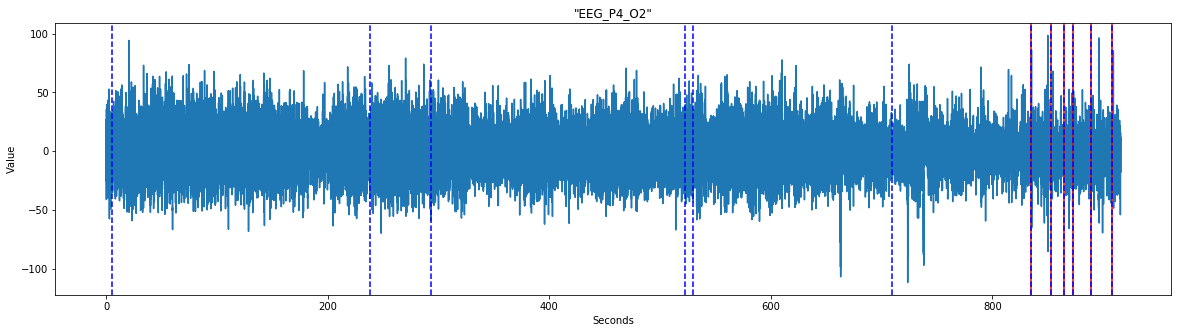

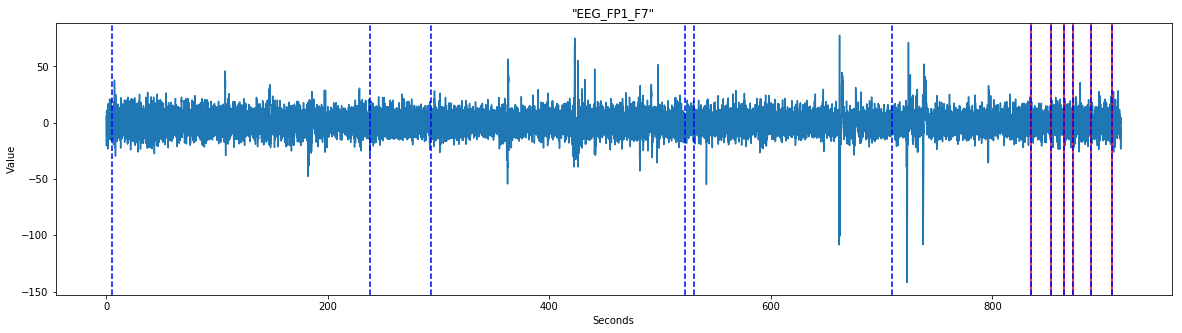

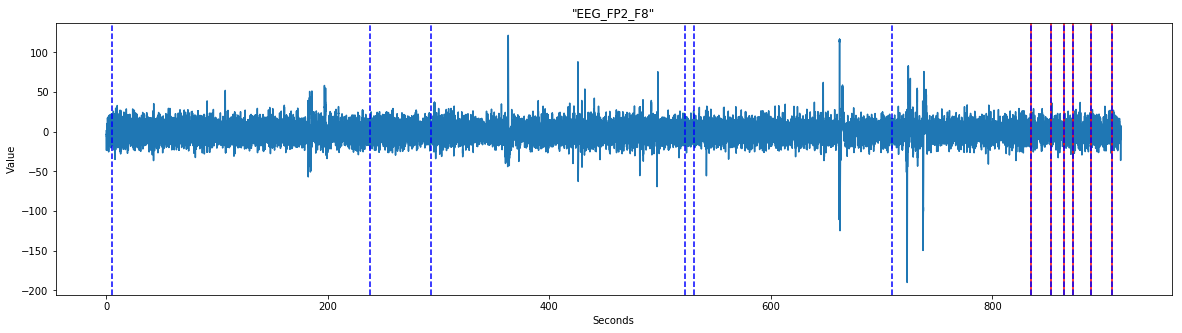

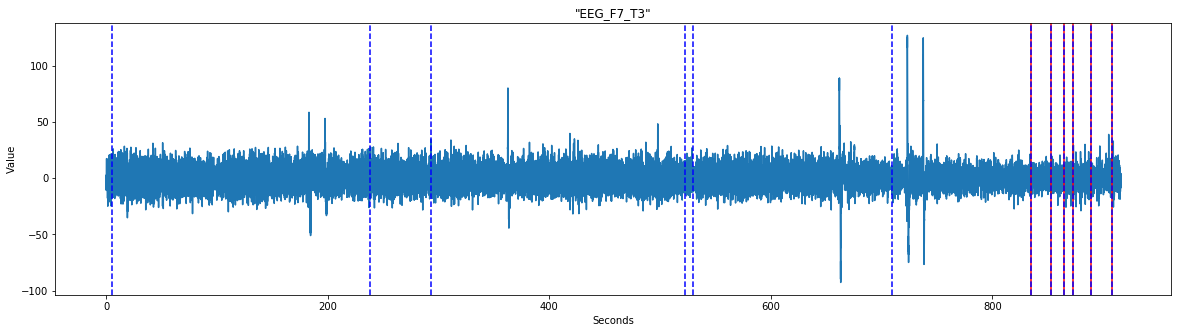

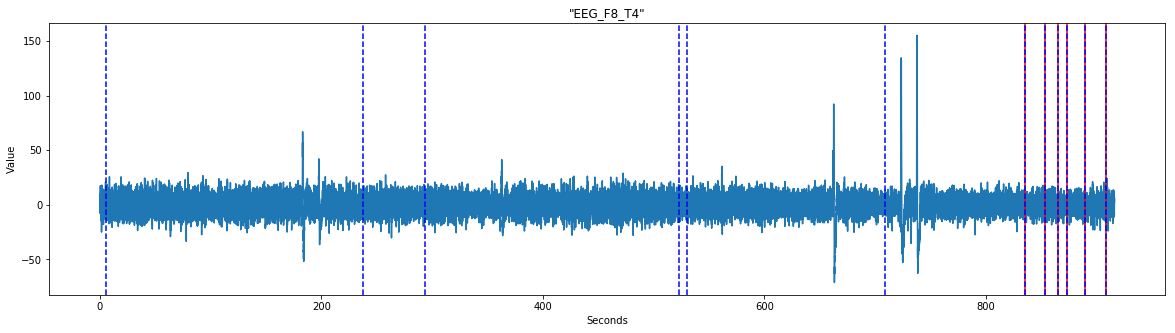

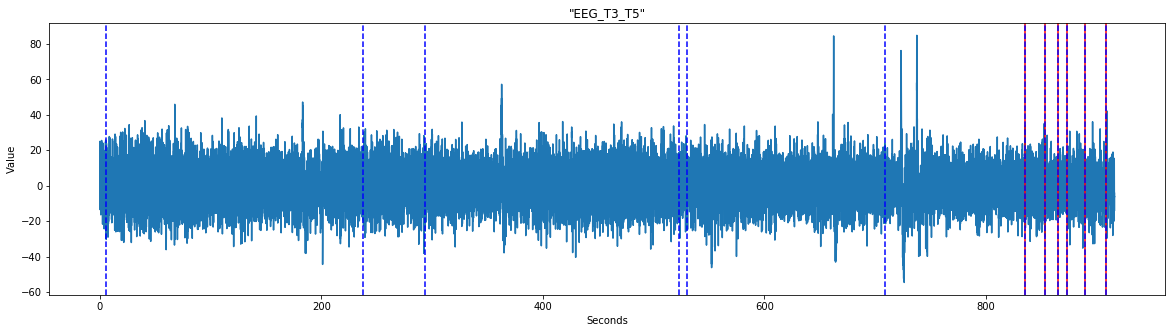

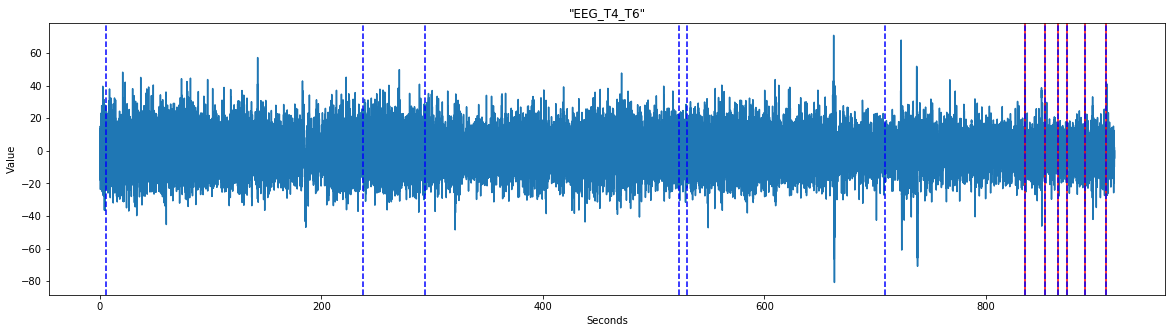

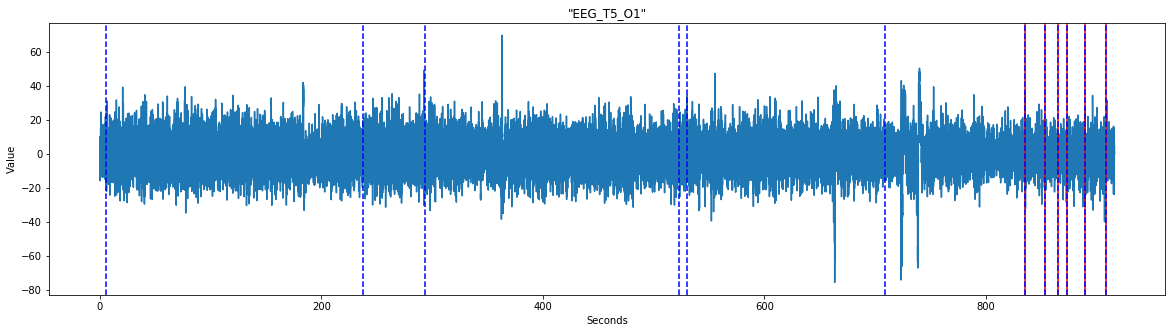

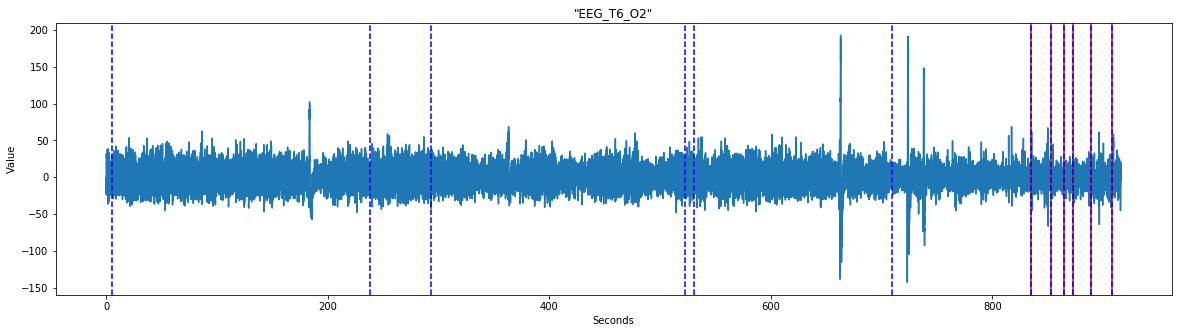

In [43]:
draw_plots_with_chunks(input_data, target, headers, patient=0, chunks_input = chunks_input, to_pdf=False)